
# 📘 Churn Prediction Notebook (End-to-End)
This notebook trains a churn model (Logistic Regression & Random Forest), evaluates it, saves the best pipeline, and runs inference on new data.


In [3]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report, average_precision_score
)
import joblib

pd.set_option("display.max_columns", None)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 34.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [scikit-learn] [scikit-learn]


In [11]:

# Step 2: Load dataset (adjust the path if needed)
df = pd.read_csv("archive/train.csv" )

# Map target to binary
if "churn" not in df.columns:
    raise ValueError("Expected a 'churn' column in the training CSV.")
df["churn_binary"] = df["churn"].map({"yes": 1, "no": 0})

X = df.drop(columns=["churn", "churn_binary"])
y = df["churn_binary"]

display(df.head())
print("Shape:", df.shape)
print("Target positive rate:", y.mean().round(4))


,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,churn_binary
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no,0
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no,0
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no,0
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no,0
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no,0


Shape: (4250, 21)
Target positive rate: 0.1407


In [12]:

# Train/test split and identify column types
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

print("Categorical:", cat_cols)
print("Numerical:", num_cols)


Categorical: ['state', 'area_code', 'international_plan', 'voice_mail_plan']
Numerical: ['account_length', 'number_vmail_messages', 'total_day_minutes', 'total_day_calls', 'total_day_charge', 'total_eve_minutes', 'total_eve_calls', 'total_eve_charge', 'total_night_minutes', 'total_night_calls', 'total_night_charge', 'total_intl_minutes', 'total_intl_calls', 'total_intl_charge', 'number_customer_service_calls']


In [13]:

# Step 4: Preprocessing (OHE for categoricals, scaling for numerics)
numeric_transformer = Pipeline([("scaler", StandardScaler())])
categorical_transformer = Pipeline([("ohe", OneHotEncoder(handle_unknown="ignore"))])

preprocess = ColumnTransformer(
    [("num", numeric_transformer, num_cols),
     ("cat", categorical_transformer, cat_cols)]
)


In [14]:

# Step 5: Train Logistic Regression & Random Forest
pipe_lr = Pipeline([
    ("preprocess", preprocess),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

pipe_rf = Pipeline([
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=300, class_weight="balanced", random_state=42
    ))
])

pipe_lr.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)
print("Models trained.")


Models trained.


In [15]:

# Step 6: Pick best model by ROC-AUC
proba_lr = pipe_lr.predict_proba(X_test)[:, 1]
proba_rf = pipe_rf.predict_proba(X_test)[:, 1]

auc_lr = roc_auc_score(y_test, proba_lr)
auc_rf = roc_auc_score(y_test, proba_rf)

if auc_rf >= auc_lr:
    best_name, best_model, y_proba = "RandomForest", pipe_rf, proba_rf
else:
    best_name, best_model, y_proba = "LogisticRegression", pipe_lr, proba_lr

print(f"Best model: {best_name} | AUC_LR={auc_lr:.3f} | AUC_RF={auc_rf:.3f}")


Best model: RandomForest | AUC_LR=0.793 | AUC_RF=0.902


In [16]:

# Step 7: Evaluation at threshold 0.5
y_pred = (y_proba >= 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_test, y_proba)
avg_prec = average_precision_score(y_test, y_proba)

print(f"Accuracy={acc:.3f}, Precision={prec:.3f}, Recall={rec:.3f}, "
      f"F1={f1:.3f}, ROC-AUC={roc_auc:.3f}, PR-AUC(AP)={avg_prec:.3f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy=0.945, Precision=0.987, Recall=0.617, F1=0.759, ROC-AUC=0.902, PR-AUC(AP)=0.840

Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       730
           1       0.99      0.62      0.76       120

    accuracy                           0.94       850
   macro avg       0.96      0.81      0.86       850
weighted avg       0.95      0.94      0.94       850


Confusion Matrix:
 [[729   1]
 [ 46  74]]


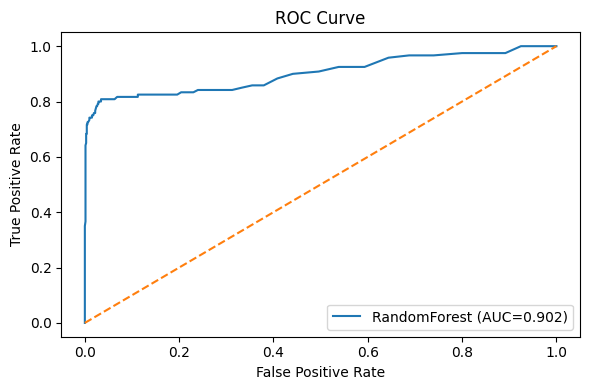

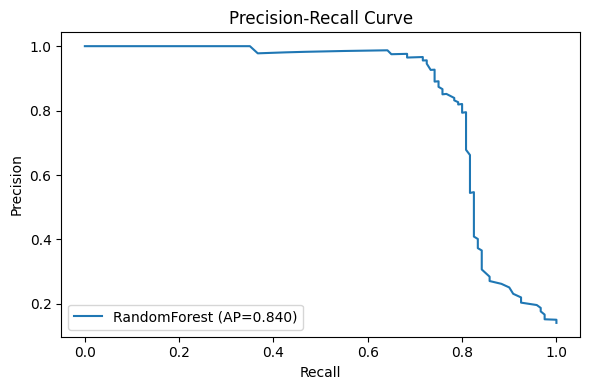

In [17]:

# ROC & PR Curves
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"{best_name} (AUC={roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve"); plt.legend(loc="lower right"); plt.tight_layout()
plt.show()

pr_prec, pr_rec, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(pr_rec, pr_prec, label=f"{best_name} (AP={avg_prec:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall Curve"); plt.legend(loc="lower left"); plt.tight_layout()
plt.show()


In [18]:

# Save the trained pipeline
MODEL_PATH = "churn_model_pipeline.joblib"
import joblib
joblib.dump(best_model, MODEL_PATH)
print(f"Model saved -> {MODEL_PATH}")


Model saved -> churn_model_pipeline.joblib


In [20]:

# Predict on new data (adjust path and uncomment to run)
NEW_DATA_CSV = "archive/test.csv"
new_data = pd.read_csv(NEW_DATA_CSV)
proba_new = best_model.predict_proba(new_data)[:, 1]
pred_new = (proba_new >= 0.5).astype(int)
out = new_data.copy()
out["churn_proba"] = proba_new
out["churn_pred"] = pred_new
out.to_csv("predictions.csv", index=False)
print("Predictions saved to predictions.csv")


Predictions saved to predictions.csv


In [ ]:

# threshold tuning helper (maximize F1)
thresholds = np.linspace(0.1, 0.9, 17)
best_thr, best_f1 = 0.5, -1.0
for thr in thresholds:
    yp = (y_proba >= thr).astype(int)
    f1_thr = f1_score(y_test, yp, zero_division=0)
    if f1_thr > best_f1:
        best_f1, best_thr = f1_thr, thr
print(f"Best F1={best_f1:.3f} at threshold={best_thr:.2f}")


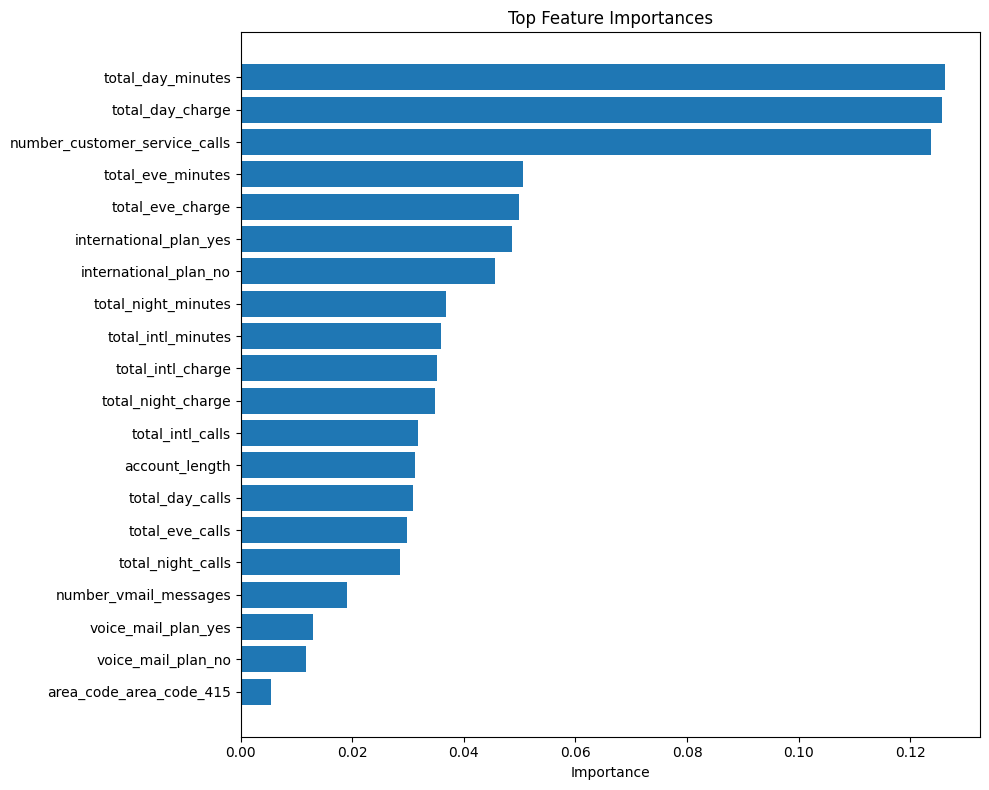

,feature,importance
0,total_day_minutes,0.126224
1,total_day_charge,0.125763
2,number_customer_service_calls,0.123794
3,total_eve_minutes,0.050647
4,total_eve_charge,0.049840
5,international_plan_yes,0.048707
6,international_plan_no,0.045536
7,total_night_minutes,0.036801
8,total_intl_minutes,0.035942
9,total_intl_charge,0.035232


In [21]:
try:
    pipe = best_model
except NameError:
    pipe = joblib.load("churn_model_pipeline.joblib")

# post-preprocessing feature names
pre = pipe.named_steps["preprocess"]
num_cols, cat_cols = [], []
for name, transformer, cols in pre.transformers_:
    if name == "num":
        num_cols = list(cols)
    elif name == "cat":
        cat_cols = list(cols)

ohe = pre.named_transformers_["cat"].named_steps["ohe"]
try:
    cat_feature_names = ohe.get_feature_names_out(cat_cols).tolist()
except Exception:
    cat_feature_names = list(ohe.get_feature_names(cat_cols))

feature_names = list(num_cols) + cat_feature_names

# importances
clf = pipe.named_steps["clf"]
metric_name = "importance"

if isinstance(clf, RandomForestClassifier):
    values = clf.feature_importances_
elif isinstance(clf, LogisticRegression):
    values = np.abs(clf.coef_.ravel())  # magnitude as importance
    metric_name = "abs_coef"
else:
    # Fallback: permutation importance (uses X_test/y_test from earlier cells)
    result = permutation_importance(pipe, X_test, y_test, n_repeats=5, random_state=42, n_jobs=1)
    values = result.importances_mean
    metric_name = "perm_importance"

feat_df = pd.DataFrame({"feature": feature_names, metric_name: values}).sort_values(metric_name, ascending=False).reset_index(drop=True)

# Top 20
topn = 20
top_df = feat_df.head(topn).iloc[::-1]  # reverse for barh
plt.figure(figsize=(10, 8))
plt.barh(top_df["feature"], top_df[metric_name])
plt.xlabel("Importance")
plt.title("Top Feature Importances")
plt.tight_layout()
plt.show()

# Save figure
plt.figure(figsize=(10, 8))
plt.barh(top_df["feature"], top_df[metric_name])
plt.xlabel("Importance")
plt.title("Top Feature Importances")
plt.tight_layout()
plt.savefig("feature_importances_top20.png", dpi=180)
plt.close()

# Preview
feat_df.head(50)